In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
rating_df = pd.read_csv('/content/drive/MyDrive/수업자료/00_dataset/movielens/ml-100k/u.data', sep='\t', header=None, names = ['userID', 'movieID', 'rating', 'timestamp'])
rating_df

,userID,movieID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


#### surprise 라이브러리를 사용한 데이터로더

In [4]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 50.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193668 sha256=d459394430add98dac53d4946f53eab6608ee00e5bf2ee4b887d15c2a6cca06c
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [5]:
from surprise import Dataset,Reader

reader = Reader(line_format="user item rating", sep="\t") ## 반드시 사용자-아이템-평점 순서로
data = Dataset.load_from_df(rating_df[['userID', 'movieID', 'rating']], reader=reader)

#surprise에서 data를 읽어오는 여러가지 방법 찾아보기

In [6]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### 예측 모델 불러오기 & 학습

In [ ]:
from surprise import KNNBasic

recom_sys = KNNBasic() 

recom_sys.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


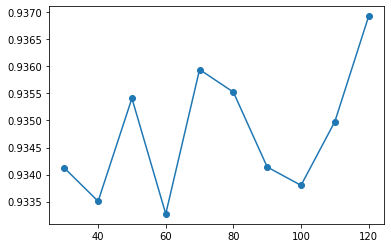

In [8]:
# [EX]
# SVD, NMF 모델 사용
import numpy as np
from surprise import SVD
from surprise.model_selection import cross_validate
from tqdm import tqdm

nf_grid = np.arange(30,130,10)

rmse_list = []
for nf in tqdm(nf_grid):
    model = SVD(n_factors = nf)
    cv_result = cross_validate(model, data, cv = 5)
    rmse = cv_result['test_rmse'].mean()
    rmse_list.append(rmse)

plt.plot(nf_grid, rmse_list, 'o-')
plt.show()
# SVD, NMF에서 latent factor(latent space dimension)의 수를 바꾸기
# KNN 모델과 성능 비교해 보기
# 최고의 성능을 내는 하이퍼 파라미터를 그리드 서치로 찾아보기

In [9]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors' : np.arange(40, 110, 10)}
grid_search = GridSearchCV(SVD, param_grid = param_grid, measures=['rmse'], cv=5)
grid_search.fit(data)

In [10]:
grid_search.best_params['rmse']

{'n_factors': 80}

In [11]:
grid_search.best_score['rmse']

0.9336072303341959

In [13]:
grid_search.cv_results['mean_test_rmse']

array([0.93413001, 0.93387225, 0.93544241, 0.93484381, 0.93360723,
       0.93612379, 0.9365151 ])

### testset에서 예측 결과 보기

In [ ]:
pred = recom_sys.test(testset)
pred[:10]

[Prediction(uid=907, iid=143, r_ui=5.0, est=4.039960584359155, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=371, iid=210, r_ui=4.0, est=4.017925064716712, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=218, iid=42, r_ui=4.0, est=3.7671897065953712, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=829, iid=170, r_ui=4.0, est=4.196945437050507, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=733, iid=277, r_ui=1.0, est=3.3353958388714653, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=363, iid=1512, r_ui=1.0, est=4.463116702100285, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=193, iid=487, r_ui=5.0, est=3.959646386658832, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=808, iid=313, r_ui=5.0, est=4.482811176968667, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=557, iid=682, r_ui=2.0, est=2.7639895884908117, details={'actua

### 임의의 user-movie의 평점 예측 결과 보기

In [ ]:
import random
print(len(testset))
random.seed(1004) #random seed
usr, mv, rating = testset[random.randint(0, 20000)] #임의의 sample 추출
usr, mv, rating

20000


(613, 603, 5.0)

In [ ]:
pred = recom_sys.predict(usr, mv)  #예측 해보기
print(pred)
print(pred.est)
print(rating)

user: 613        item: 603        r_ui = None   est = 4.59   {'actual_k': 40, 'was_impossible': False}
4.593353929815936
5.0


In [ ]:
movie_info_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin', header=None)
movie_info_df.columns = ['movieID' , 'movie_title' , 'release_date' , 'video_release_date' ,
                        'IMDb_URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
                        'Children' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
                        'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,
                        'Thriller' , 'War' , 'Western']
movie_info_df

,movieID,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 영화 이름 출력하기

In [ ]:
movie_name = movie_info_df.loc[mv]
print(movie_name['movie_title'], '- predicted score : ', pred.est, 'real score :', rating)
print(f'{movie_name.movie_title} - predicted score : , {pred.est:.2f}, real score : {rating}')

It Happened One Night (1934) - predicted score :  4.593353929815936 real score : 5.0
It Happened One Night (1934) - predicted score : , 4.59, real score : 5.0


#### 추천 시스템을 돌릴 대상 영화 ID 리스트 추출하기

In [ ]:
all_movie_ids = movie_info_df.index
all_movie_ids

RangeIndex(start=0, stop=1682, step=1)

In [ ]:
watched_movie_ids = rating_df[rating_df['userID']==usr].movieID
watched_movie_ids

35427     258
37697     303
42128     471
42616      64
45280      28
46631     127
47769     126
50897       1
52097     509
53529     194
55197     607
57167     514
62430     632
64521    1315
67522     272
73737     435
74415     576
75422     478
76975      50
77841     318
78418     297
78606     176
84600     530
88772    1157
93715     603
94717      89
94720      12
98507     279
Name: movieID, dtype: int64

In [ ]:
# python 컨테이너 중 하나인 set!
unwached_movie_ids = set(all_movie_ids) - set(watched_movie_ids)
len(unwached_movie_ids)

1654

#### 보지 않은 모든 영화의 평점을 예측하고 저장

In [ ]:
all_pred_scores = []

for mv_id in unwached_movie_ids:
    pred = recom_sys.predict(usr, mv_id)
    single_pred_result = {'movieID' : mv_id, 'recom_score' : pred.est}
    all_pred_scores.append(single_pred_result)

all_pred_scores[:10]

[{'movieID': 0, 'recom_score': 3.5318875},
 {'movieID': 2, 'recom_score': 3.397420508285552},
 {'movieID': 3, 'recom_score': 3.246922430403019},
 {'movieID': 4, 'recom_score': 4.054947320699349},
 {'movieID': 5, 'recom_score': 3.353167066849124},
 {'movieID': 6, 'recom_score': 3.3538127362519123},
 {'movieID': 7, 'recom_score': 3.9114461854610845},
 {'movieID': 8, 'recom_score': 3.9257276492891844},
 {'movieID': 9, 'recom_score': 4.007122799808232},
 {'movieID': 10, 'recom_score': 4.1051895099917}]

#### dataframe으로 변환

In [ ]:
recom_score_df = pd.DataFrame(all_pred_scores)
recom_score_df

,movieID,recom_score
0,0,3.531887
1,2,3.397421
2,3,3.246922
3,4,4.054947
4,5,3.353167
...,...,...
1649,1677,3.000000
1650,1678,1.000000
1651,1679,3.000000
1652,1680,2.000000


#### 두 dataframe 합치기

In [ ]:
result_df = pd.merge(movie_info_df, recom_score_df, on='movieID')
result_df

,movieID,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,recom_score
0,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,3.397421
1,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3.246922
2,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.054947
3,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3.353167
4,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.353813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648,1677,Sweet Nothing (1995),20-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Sweet%20Nothi...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.000000
1649,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
1650,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,3.000000
1651,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2.000000


In [ ]:
result_df = result_df.sort_values('recom_score', ascending=False)
result_df

#### 최종 결과 출력

In [ ]:
result_df.iloc[:5][['movie_title', 'recom_score']]

#다른 방법!
# result_df.reset_index(drop=True)
# result_df.loc[:5][['movie_title', 'recom_score']]

## Item-based VS User-based

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate

# item-based 모델 생성
item_based = KNNBasic(sim_options={'user_based': False})

# user-based 모델 생성
user_based = KNNBasic(sim_options={'user_based': True})

# 교차 검증
item_based_cv = cross_validate(item_based, data, cv=5, verbose=True)
user_based_cv = cross_validate(user_based, data, cv=5, verbose=True)

# 결과 출력
print(f'Item-based 모델 평균 RMSE: {item_based_cv["test_rmse"].mean():.3f}')
print(f'User-based 모델 평균 RMSE: {user_based_cv["test_rmse"].mean():.3f}')


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9729  0.9747  0.9778  0.9664  0.9770  0.9738  0.0041  
MAE (testset)     0.7706  0.7701  0.7685  0.7662  0.7735  0.7698  0.0024  
Fit time          0.51    0.81    0.64    0.54    0.73    0.65    0.11    
Test time         3.90    9.50    4.06    4.46    4.20    5.22    2.15    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing s

In [ ]:
# KNN 계열 다른 모델 사용해서 비교해보기
# 다른 유사도를 사용해서 비교해보기

from surprise import KNNBaseline, KNNWithZScore

# item-based 모델 생성
item_based_1 = KNNBaseline(sim_options={'user_based': False})
item_based_2 = KNNWithZScore(sim_options={'user_based': False})

# user-based 모델 생성
user_based_1 = KNNBaseline(sim_options={'user_based': True})
user_based_2 = KNNWithZScore(sim_options={'user_based': True})

# 교차 검증
item_based_cv_1 = cross_validate(item_based_1, data, cv=5, verbose=True)
user_based_cv_1 = cross_validate(user_based_1, data, cv=5, verbose=True)

item_based_cv_2 = cross_validate(item_based_2, data, cv=5, verbose=True)
user_based_cv_2 = cross_validate(user_based_2, data, cv=5, verbose=True)

# 결과 출력
print('-'*300)
print(f'Item-based 모델(KNNBaseline) 평균 RMSE: {item_based_cv_1["test_rmse"].mean():.3f}')
print(f'User-based 모델(KNNBaseline) 평균 RMSE: {user_based_cv_1["test_rmse"].mean():.3f}')
print('-'*300)
print(f'Item-based 모델(KNNWithZScore) 평균 RMSE: {item_based_cv_2["test_rmse"].mean():.3f}')
print(f'User-based 모델(KNNWithZScore) 평균 RMSE: {user_based_cv_2["test_rmse"].mean():.3f}')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9404  0.9312  0.9234  0.9289  0.9371  0.9322  0.0060  
MAE (testset)     0.7395  0.7324  0.7262  0.7307  0.7356  0.7329  0.0045  
Fit time          0.81    0.78    0.78    1.11    0.76    0.85    0.13    
Test time         7.91    4.54    4.91    4.37    4.34    5.22    1.36    
Estimating biases using als...
Computing th